In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount the google driver

Mounted at /content/drive


In [ ]:
pwd

'/content'

In [ ]:
cd drive/MyDrive/RNNModel/remapping/run/

/content/drive/MyDrive/RNNModel/remapping/run




Created by Xiao Wang - 07/29/2023

Modified by Xiao Wang - 12/12/2023


1) Add gamma function input

2) Change cd signal from 3 bits to 2 bits

3) Attention locus follows target from initial postition to fovea in retinotopic map

In [ ]:
# make folder to save the data and figures
import os
if not os.path.exists('img/'):
  os.makedirs('img/')
if not os.path.exists('cpkt/'):
  os.makedirs('cpkt/')


Buid the dataset


In [ ]:

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torchvision
import sys
from scipy import signal,special
from scipy.stats import gamma
import math
class gaussian_bump(object):
    """
    Dataset of 1-D guassian moving bump
    input:
       N             : input size
       Ntask         : number of tasks
       Ndirec        : number of directions (right and left)
       visualRange   : visual input range e.g.(-50~50 degree)
       sacon         : time of saccade onset (ms)
       input_pattern : flag of training paradigm, 0 means memory only, 1 means visually guided only, 2 means combined.
       supress       : flag of whether saccade supression considered
       sigma         : sigma of the gaussian bump
       gammaInput    : flag of the input as gamma function or step function
       step_cd       : flag of the type of cd signal,True is step function, False is smooth function
    output:
       see the more details in function build_dataset()

    """
    def __init__(self,N,Ntask,Ndirec,visualRange,startpos,sacon,input_pattern=0,supress=True,sigma=10.,gammaInput=True,step_cd = True):
        """
        Initialize function.

        """

        self.N = N
        self.Ntask = Ntask
        self.Ndirec = Ndirec
        self.visualRange = visualRange
        self.delta_theta = visualRange/N # degrees per pixel
        self.supress = supress
        self.sigma = sigma
        self.startpos = startpos
        self.input_pattern = input_pattern
        self.sacon = sacon
        self.gammaInput = gammaInput # True is use gamma function, False is step function
        self.gammaShape = 5
        self.gammaScale = 10
        self.eyetrace = self._eyetrace() # internal use function to create the saccade trace
        self.sacamp = self.eyetrace[-1]  # get the saccade amplitude
        self.sacDur   = len(self.eyetrace) # get the duration of saccade
        self.sacend = self.sacon + self.sacDur # compute the end time of saccade


        self.sigma_supress = 0.7 #

        self.stiDelay = 50 # 35 ms visual delay (ms)
        self.outpad = 50   # duration of the static bump after saccade end  (ms)
        self.spDur = 200 # saccade supression duration (ms)
        #self.sacDelay = 50 # (ms) not used
        self.tot_len = self.sacend+self.stiDelay+self.outpad
        if step_cd:
           self._getcd = self._get_step_cd # step cd signal

        else:
           self._getcd = self._get_smooth_cd # smooth cd signal


    def _gaussian(self,x):
        """
        1-D guassian bump without periodical boundary
        Input   x : position of  center of gaussian bump (pixel)
        Output  g : 1-D guassian bump (N,)

        """


        theta = np.arange(0, self.visualRange,self.delta_theta)
        g = np.exp(-(theta-x*self.delta_theta)**2/2./self.sigma**2)


        return  g   # Delete the unnecessary dimension
    def _gaussian_circ(self,x):
        """
        Not used
        1-D guassian bump with Periodical boundary
        Input   x : position of  center of gaussian bump (pixel)
        Output  g : 1-D guassian bump  (N,)

        """

        delta_theta =  self.visualRange/self.N
        theta = np.arange(0, self.visualRange,delta_theta)
        delta_theta =  self.visualRange/self.N
        theta = np.arange(0, self.visualRange,delta_theta)
        mu_shifted = np.mod(x*self.delta_theta-theta[0],visualRange) + theta[0]

        nd = abs(theta-mu_shifted)
        nd = np.minimum(nd,visualRange-nd)

        g = np.exp(-0.5*nd**2/self.sigma**2)
        #pdb.set_trace()
        return g #shape  (320,)
    def _eyetrace(self):
        """
        Create the eye trace by
        Using sigmoid function to simulate eye trace during saccade

        """

        xbins = np.linspace(-10, 10, 100)
        z = 1/(1 + np.exp(-xbins*0.53))
        eyetrace= z[25:75]*25 #  saccade duration is 50ms and amplitude is ~25 degrees
        eyetrace = eyetrace-eyetrace[0]
        return eyetrace

    def _get_static_bumps(self,dur,s=0):
       """
       create static gaussian bumps for padding, dur is the duration of the bumps (ms)
       """

       g = self._gaussian(s)
       #pdb.set_trace()
       g = np.broadcast_to(g,(dur,g.shape[0]))
       return g
    def _gammaInput(self):
      """
      Gamma function
      """
      t = np.linspace(0,self.tot_len,self.tot_len)
      amp = gamma.pdf(t,self.gammaShape,0,self.gammaScale) # shape=5,loc=0ms(start at 0ms),scale=10ms
      amp = amp/np.max(amp)
      #amp[100:] = 0.0
      #plt.plot(amp)
      #pdb.set_trace()
      return amp
    def _get_step_cd(self):
      """

      Create the step version of time course of 2-bits cd signal for right and left moving bump
      sacDur = len(self.eyetrace)

      """
      # Intialize the cd matrix (NumOfTasks,NumOfDirections,N,Time,3)
      cd = torch.zeros(self.Ntask,self.Ndirec,self.N,self.tot_len,2)# torch.zeros(self.Ntask,self.Ndirec,self.N,self.tot_len,2)


      # set correct cd during saccade
      for t in range(self.sacon,self.sacend):
          cd[:,0,:,t,0] = 1 # 1st bit for right moving
          cd[:,1,:,t,1] = 1 # 2nd bit for left moving


      #cd[:,:,:,:self.stiDelay,:] = 0 # Don't output anything at the beginning 50ms
      return cd
    def _get_smooth_cd(self):
      """

      Create the smooth version of time course of 2-bits cd signal for right and left moving bump
      sacDur = len(self.eyetrace)

      """
      # Intialize the cd matrix (NumOfTasks,NumOfDirections,N,Time,3)
      cd = torch.zeros(self.Ntask,self.Ndirec,self.N,self.tot_len,2)

      #cd[:,:,:,:,2] = 1 # the 3rd bit responsible for generating the stable gaussian bumps
      mid_sac = (self.sacon+self.sacend)//2
      # set correct cd during saccade
      tbin =  torch.linspace(-100,100,200)
      z = torch.exp(-torch.abs((tbin/30))**6)
      cd_start = mid_sac-100
      cd_end   = mid_sac+100
      cd[:,0,:,cd_start:cd_end,0] = z # 1st bit for right moving
      cd[:,1,:,cd_start:cd_end,1] = z # 2nd bit for left moving



      #cd[:,:,:,:self.stiDelay,:] = 0 # Don't output anything at the beginning 50ms
      return cd

    def _get_bumps(self,s=0):
        """
        Create the input gaussian bump start from s (pixel)
        when t ~ [0,self.sacon+self.stiDelay] the gaussian bump is static
        when t ~ [self.sacon+self.stiDelay,end] the gaussian bump is moving, the instaneous postion is from self.eyetrace
        """


        tmp_tot_len = self.sacend+self.stiDelay # total time before output padding
        patterns = np.zeros((tmp_tot_len,self.N)) # initialize the pattern matrix
        patterns[:self.sacon+self.stiDelay] = self._get_static_bumps(self.sacon+self.stiDelay,s)

        for t in range(self.sacon+self.stiDelay,tmp_tot_len):
            patterns[t,:]=self._gaussian(self.eyetrace[t-self.sacon-self.stiDelay]+s) ## ??
        return patterns #np.roll(patterns,0)





      #cd[:,:,:,:self.stiDelay,:] = 0 # Don't output anything at the beginning 50ms

    def _getAttenPos(self):
      """
      Create position of attentional modulation which is the input in the retinotopic location

      """
      attpos = np.zeros(self.tot_len)
      attpos[:self.sacon] = self.sacamp
      attpos[self.sacon:self.sacend] = self.sacamp-self.eyetrace
      return attpos

    def _dataset(self):
        """
        Helper function for generating dataset

        stim1_input, right moving input gaussian bumps (NumOfSamples,time,InputSize)
        stim2_input, left moving input gaussian bumps (NumOfSamples,time,InputSize)

        stim1_output, right moving output gaussian bumps (NumOfSamples,time,InputSize)
        stim2_output, left moving output gaussian bumps (NumOfSamples,time,InputSize)

        """
        tot_len = self.tot_len
        stim1_input = np.zeros((self.N,tot_len,self.N))
        stim2_input = np.zeros((self.N,tot_len,self.N))

        stim1_output = np.zeros((self.N,tot_len,self.N))
        stim2_output = np.zeros((self.N,tot_len,self.N))
        #stim3 = np.zeros((self.N,self.sacend+sacDur*2,self.N))

        for i in np.arange(len(self.startpos)):
            end_pos =  self.startpos[i] + self.sacamp # end position of the moving bump
            end_pad = self._get_static_bumps(self.outpad,end_pos) # generate the padding static bumps at the end of saccade.
            #end_pos_left  =  self.N-1-start_pos - self.sacamp

            # Get the right input patterns with end padding
            stim1_input[i,:-self.outpad] = self._get_bumps(self.startpos[i])
            stim1_input[i,-self.outpad:] = end_pad
            # Get the left input patterns by flipping the right input
            stim2_input[i] = np.flip(stim1_input[i],1)

            # Get output
            output_pad1 = self._get_static_bumps(self.stiDelay+self.outpad,end_pos) # output padding static bumps
            output_pad2 = self._get_static_bumps(self.stiDelay+self.outpad,self.N-1-self.startpos[i] - self.sacamp) # output padding static bumps
            # Static part of output patterns
            stim1_output[i,:self.sacon,:] = stim1_input[i,:self.sacon,:]
            stim2_output[i,:self.sacon,:] = stim2_input[i,:self.sacon,:]
            # Moving part of output patterns
            stim1_output[i,self.sacon:self.sacon+self.sacDur,:] = stim1_input[i,self.sacon+self.stiDelay:self.sacon+self.stiDelay+self.sacDur,:]
            stim2_output[i,self.sacon:self.sacon+self.sacDur,:] = stim2_input[i,self.sacon+self.stiDelay:self.sacon+self.stiDelay+self.sacDur,:]
            # Padding
            stim1_output[i,-self.stiDelay-self.outpad:,:] = output_pad1
            stim2_output[i,-self.stiDelay-self.outpad:,:] = output_pad2



        return stim1_input,stim2_input,stim1_output,stim2_output
    def build_dataset(self):
        """
         Build the final dataset, combined with cd signal

         input_nm : visually guided saccade task (non-memory), with saccadic supression or without supression
         input_m  : memory guided saccade task

        """
        s1,s2,o1,o2 = self._dataset()
        o1[:,0:self.stiDelay,:] = 0.0 # no output at the beginning 50 ms
        o2[:,0:self.stiDelay,:] = 0.0
        input_nm = np.stack((s1,s2),axis=0)  # concate the right and left input patterns together
        input_m  = input_nm.copy()
        #pdb.set_trace()
        if self.gammaInput: ## use gamma function as inputs
          gammaInput = self._gammaInput()
          input_m = input_m* gammaInput[None,None,:,None]
          #pdb.set_trace()
          index = np.argmax(gammaInput)
          gammaInput[index:] = 1
          input_nm = input_nm * gammaInput[None,None,:,None]
        else: ## use step function as input
          input_m[:,:,self.stiDelay:,:] = 0.0  # memory


        input_m = torch.from_numpy(input_m) # to Pytorch tensor datatype
        input_nm = torch.from_numpy(input_nm)
        outputSti = np.stack((o1,o2),axis=0) # # concate the right and left output patterns together
        outputSti = torch.from_numpy(outputSti) # to Pytorch tensor datatype
        if self.supress:
            smask =  self.gauss_supres(200)
            #input_s = input_nm.copy()
            supress_start = sacon+len(self.eyetrace)//2-self.spDur//2 # 100ms supress time window, max at peak of sacaade
            supress_end = sacon+len(self.eyetrace)//2+self.spDur//2

            input_nm[:,:,supress_start:supress_end,:] = input_nm[:,:,supress_start:supress_end,:] *smask
        #pdb.set_trace()
        # get and concate cd signal
        cd = self._getcd() # get the cd signal
        if self.input_pattern == 0: # memory guided
         inputSti = torch.stack((input_m,input_m),axis=0)
        if self.input_pattern == 1: # visually guided
          inputSti = torch.stack((input_nm,input_nm),axis=0)
        if self.input_pattern == 2: # combined
          inputSti = torch.stack((input_m,input_nm),axis=0)
        #inputSti = inputSti
        inputSti = torch.cat((inputSti,cd),-1) # concate the cd and input
        return inputSti,outputSti


class predicStim(Dataset):
    """

     wrappe the dataset for Pytorch

    """
    def __init__(self,Ncut,Ntot,visualRange,sacon,input_pattern = 0,sacSupress=True,sigma = 10.0,stiDelay = 50,gammaInput = True,cd_step = True):
       self.Ncut = Ncut #  Num of pixels was used to eliminate the boundary effect
       self.Ntot = Ntot #  Num of visual input pixels
       self.Ntask = 2
       self.Ndirec = 2
       self.visualRange = visualRange
       self.sacon = sacon
       self.input_pattern = input_pattern
       self.gammaInput = gammaInput
       self.cd_step = cd_step
       self.sacSupress = sacSupress
       self.sigma = sigma
       self.stiDelay = stiDelay
       self.startpos =  np.arange(0,Ntot,1)
       self.gaussian_dataset = gaussian_bump(Ntot,self.Ntask,self.Ndirec,self.visualRange,self.startpos,self.sacon,self.input_pattern,self.sacSupress ,self.sigma,self.gammaInput,self.cd_step)
       self.attPos = self.gaussian_dataset._getAttenPos() # get attentional locus which follow the input in retinotopic map
       self._visInput, self._visOutput = self.gaussian_dataset.build_dataset()
       #self.testprobe_func = self.gaussian_dataset.testprobe







    def __getitem__(self,idx):
        # self._visInput.shape = (ntask,ndirec,npos,timesteps,n+3),npos = n, 3 bits cd signal
        # self._visOutput.shape = (ndirec,npos,timesteps,n)
        #data_shape  = np.array(self._visInput.shape[0:3])
        data_shape = np.array([self.Ntask,self.Ndirec,self.Ncut])

        taski, direi, posi = np.unravel_index(idx,data_shape) # get the task direction and postion index

        if direi == 1: # left moving (rightward saccade, attention from 25(deg) to 0(fovea))
            attPos = self.attPos
        else:# right moving (left saccade, attention from 75(deg) to 100(fovea))
            attPos = self.Ntot-self.attPos
        visInput  =  self._visInput[taski, direi, posi+(self.Ntot-self.Ncut)//2]
        visOutput =  self._visOutput[direi, posi+(self.Ntot-self.Ncut)//2]
        return visInput, visOutput,attPos


    def __len__(self):
        return self.Ncut*self.Ndirec*self.Ntask


if __name__ == '__main__':
    #Quick test of the dataset code for degug
    FullN = 100
    N = 50
    visualRange = 100 # deg
    startpos = np.arange(0,N,1)
    sacon = 150 # ms
    stiDelay = 50
    gammaSacle = 5
    window = signal.gaussian(100, std=15.8) # 11.8
    w_ = np.floor(np.cumsum(window))*1.5
    sigma = 7
    input_pattern = 0

    t0 = [i for i in w_ if i == 0]
    speed = w_.astype('int')
    speed = speed[len(t0):-len(t0)]

    x = np.linspace(-10, 10, 100)
    z = 1/(1 + np.exp(-x*0.3))
    speed= z[0:75]*80
    #speed = speed.astype('int')

    dataset = predicStim(N,FullN,visualRange,sacon,input_pattern,False,sigma,50,False,False)
    gaussian_dataset = gaussian_bump(N,2,2,visualRange,startpos,sacon,False,6)
    #testProbe = gaussian_dataset.testprobe(30)
    #gammaInput = gaussian_dataset.gammaInput(150,shape=2,scale=5)
    #plt.plot(gammaInput)
    #x = np.linspace (0, 40, 150)
    #y = gamma.pdf(x, a=2, scale=5)
    #plt.plot(y/np.max(y))
    #plt.plot(speed)
    # result = a*b[:,None]

<ipython-input-8-afef9cac48c3>:375: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  window = signal.gaussian(100, std=15.8) # 11.8


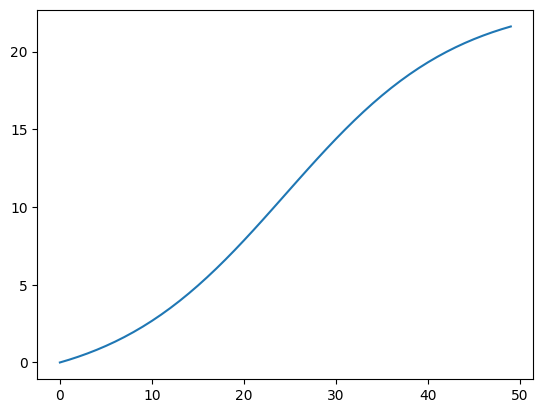

In [ ]:
plt.plot(gaussian_dataset.eyetrace)

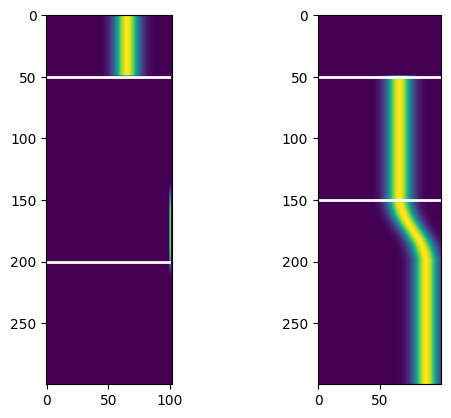

In [ ]:
visInput, visOutput,start_posi = dataset[40]
plt.subplot(121)
plt.imshow(visInput)
plt.plot([0,FullN-1],[stiDelay,stiDelay],color='w',linewidth=2)
plt.plot([0,FullN-1],[150+stiDelay,150+stiDelay],color='w',linewidth=2)
plt.subplot(122)
plt.imshow(visOutput)
plt.plot([0,FullN-1],[stiDelay,stiDelay],color='w',linewidth=2)
plt.plot([0,FullN-1],[150,150],color='w',linewidth=2)
#plt.plot([0,199],[200,200],color='w',linewidth=2,linestyle='--')
    #plt.imshow(oo[1,20])
#cd = data._getcd()
cd = visInput[:,-2:]

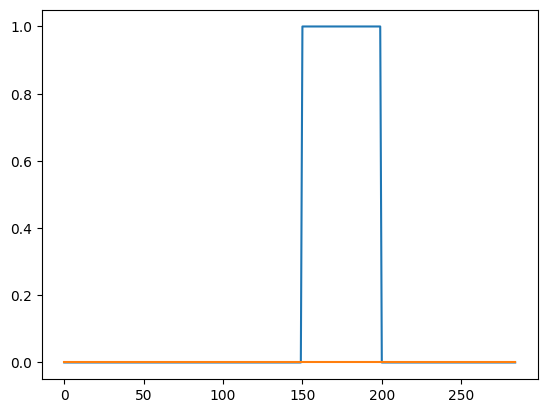

In [ ]:
plt.plot(cd)

In [ ]:
len(dataset)

200

Defining a recurrent neural network

In [ ]:
class RNNNet(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size1: Number of visual input neurons
        input_size2: Number of cd input neurons
        hidden_size: Number of hidden neurons
        attPos     : Position of attention modulation (same with the center of input gaussian bump)

    Inputs of the forward function:
        input: (seq_len, batch, input_size1+input_size2), network input
        attPos: (batch,1), attention modulation
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size1, input_size2,hidden_size,tau=30,dt=1):
        super().__init__()
        self.input_size1 = input_size1
        self.input_size2 = input_size2

        self.hidden_size = hidden_size
        self.tau = tau # time constant
        if dt is None:
            self.alpha = 1
        else:
            self.alpha = dt / self.tau

        #self.oneminusalpha = 1 - self.alpha

        # rnn connections,put the Wasymetic(right and left moving) and Wsysymetic together.
        self.full_h2h = nn.Linear(hidden_size*(input_size2+1),hidden_size,bias=True) # (3*hidden_size, hidden_size)
        #self.connecMatrix = torch.nn.Parameter(torch.rand(hidden_size,hidden_size*input_size2),requires_grad=True)

        #self.cd2h = nn.Sequential(nn,nn.sigmoid())
        self.input2h = nn.Conv1d(1,1,5 ,1,2,bias=True)# input to hidden layer kernel

        self.W_atten = 0.4  # attention modulation strength
        self.sigma_atten = 15 # sigma of attention modulation
        self.initial_parameters()
        self.ac_func = torch.relu

        self.scale_conv = 1
        self.scale_linear = 1

        #self.ac_func = torch.nn.ReLU6()
        #self.ac_func = torch.nn.Sigmoid()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def gaussian(self,x):
        """
        Not used
        Generate a gaussian curve for attention modulation
        """
        # gaussian attention modulation
        # x : postion of visual input
        # batch_size = size of x.shape[0]
        N = self.hidden_size
        batch_size  = x.shape[0]

        theta = np.arange(0,N).reshape(1,-1)
        theta = np.repeat(theta,batch_size,axis = 0)
        _x = x[:,np.newaxis]
        x_theta = theta-_x
        y=self.W_atten*np.exp(-x_theta**2/2./self.sigma_atten**2)
        return torch.from_numpy(y).float().to(self.device)
    def gaussian_atten(self,x):
        """
        1-D guassian bump with Periodical boundary
        Input   x : scalar position of  center of gaussian bump (pixel)
        Output  g : 1-D guassian bump  (N,)

        """


        N = self.hidden_size
        batch_size  = x.shape[0]
        theta = np.arange(0,N).reshape(1,-1)
        theta = np.repeat(theta,batch_size,axis = 0)
        _x = x[:,np.newaxis]
        #pdb.set_trace()
        mu_shifted = np.mod(_x-theta[0],N) + theta[0]

        nd = abs(theta-mu_shifted) # distance between a position and attention locus
        nd = np.minimum(nd,N-nd) #

        g = self.W_atten*np.exp(-0.5*nd**2/self.sigma_atten**2)
        #pdb.set_trace()
        return torch.from_numpy(g).float().to(self.device)
    def init_hidden(self, input_shape):
        # initial function of hidden state
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)
    def initial_parameters(self):
        # initial function uniform[-1/sqrt(N),1/sqrt(N)]
        for m in self.modules():
            if isinstance(m,nn.Conv1d):
                n=m.kernel_size[0] * m.out_channels
                m.weight.data.uniform_(-np.math.sqrt(1./n),np.math.sqrt(1./n))
            elif isinstance(m,nn.Linear):
                #n=m.kernel_size[0] * m.out_channels
                m.weight.data.uniform_(-np.math.sqrt(1./self.hidden_size),np.math.sqrt(1./self.hidden_size))
    def recurrence(self,input,hidden,attPos):
        """
        Implement neural dynamics, run network for one time step.

        Inputs:
            input  : visual input and cd , tensor of shape (batch, input_size1 + input_size1 )
            hidden : hidden layer state, tensor of shape (batch, hidden_size)
            attPos : position of attention modulation tensor of shape (batch,1)

        Outputs:
            h_new: new hidden layer state tensor of shape (batch, hidden_size),
            rec  : recurrent activities before adding the inputs
        """

        # split input into visual and cd input
        input1,input2 = input[:,:self.input_size1],input[:,-self.input_size2:]
        # add extra dimension to match nn.conv1d
        input1 = input1.unsqueeze(1).float() # (batch, input_size1) -> (batch, 1, input_size1)
        input2 = input2.float()
        # input2 = torch.nn.ReLU6(self.input2h2(input2))
        # visual input to hidden layer
        #pdb.set_trace()
        input_act1 = self.input2h(input1)  # input to hidden layer

        input_act1 = input_act1.squeeze(1) # remove the extra dimension (batch,1 input_size1) -> (batch, input_size1)
        #attMod = self.gaussian(attPos)
        attMod = self.gaussian_atten(attPos) # get the attention modulation mask  (batch, hidden_size )


        rec_ = [] # initial a list to collect the recurrent activity
        for i in range(input1.size(0)): # size(0) is batch size
            h_ = hidden[i].view(self.hidden_size,1) # (hidden_size,) -> (hidden_size,1)
            attMod_ = attMod[i].view(self.hidden_size,1) # attention modulation mask (hidden_size,1)
            #pdb.set_trace()

            h_ = (1+attMod_)* h_ # modulate the hidden state
            tmp_h = h_.view(1,-1)




            # repeat the hidden state for different set of weight (right/left/static bump)
            h_ = h_.repeat(1,self.input_size2) # (hidden_size,1) -> (hidden_size,3)
            h_ = h_.view(1,self.hidden_size*self.input_size2) # (hidden_size,3) -> (1,hidden_size*3)

            # reshape the cd signal to the same size as hidden state h_
            input2_ = input2[i].view(1,self.input_size2)
            #pdb.set_trace()
            input2_ = input2_.repeat(1,self.hidden_size)


            r_ = torch.mul(h_,input2_) # cd gated the hidden state
            #r_ = torch.cat((r_,hidden[i].view(1,-1)),dim=1)
            r_ = torch.cat((r_,tmp_h),dim=1)
            #pdb.set_trace()

            rec_.append(r_)



        rec_ = torch.cat(rec_,dim=0)
        rec = self.full_h2h(rec_) # hidden to hidden connection
        #pdb.set_trace()
        pre_activation = input_act1 + rec # add the input

        # h(t+1) = relu( h(t)*(1-alpha) + input * alpha )
        h_new = self.ac_func(hidden * (1 - self.alpha) +
                         pre_activation * self.alpha)


        return h_new,rec




    def forward(self, input,attPos=None, hidden=None):
        """
        input : (time_steps,batch_size,inputsize)
        """
        # initial the hidden state and move it to the input device (cpu/gpu)
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)


        output = [] # output list
        r_ = [] # temp variable list
        steps = range(input.size(0)) # get the time steps
        #pdb.set_trace()
        # loop the time steps
        for i in steps:

            hidden,rec= self.recurrence(input[i], hidden,attPos[i])
            output.append(hidden)
            r_.append(rec)
        # reshape the output to (time_steps, batch_size, output_size)
        output = torch.cat(output, 0).view(input.size(0), *output[0].size())
        r_ = torch.cat(r_,0).view(input.size(0),*output[0].size())
        return output,r_

if __name__  == '__main__':
  # Quick test of the model for debug
  test_model = False
  Visualinputsize = 100 # input size and network size
  CDinputsize = 2 # cd signal size
  hiddensize=100 # hidden layer size of rnn
  # define the model
  model =  RNNNet(Visualinputsize,CDinputsize,hiddensize)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  p = np.random.randint(0, 199, size=32, dtype=int)
  p = np.zeros((50,32))
  x  = torch.rand(50,32,102)
  x = x.to(device)
  output,rec  = model(x,p)
  g = model.gaussian_atten(np.array([25,50]))

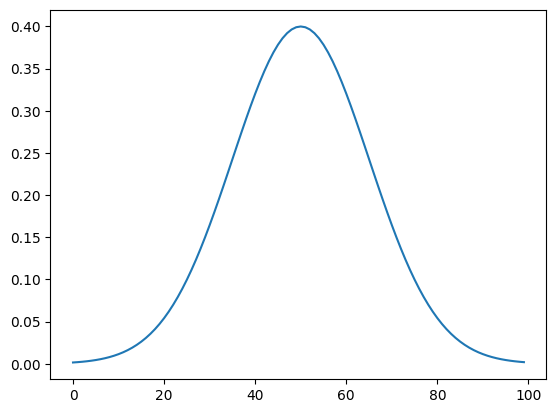

In [ ]:
plt.plot(g[1])

Run the simulation and save the results

In [ ]:
# Main training script
if __name__  == '__main__':
     # This is the main code
     Visualinputsize = 50 # only use the middle 50 pixels as the center of input bump
     TotN = 100 # Input size
     CDinputsize = 2# cd signal size
     hiddensize=TotN # Hidden layer size of rnn
     visualRange = 100 # -50~50 degree
     stiDelay = 50
     gammaInput = False
     step_cd = False
     SacSupress = False # flag of saccade supression
     #time_step = 250 #150
     #start_time = 250
     saccde_onset = 150 # saccade onset  150ms
     visual_sigma = 5 # 7 6.5
     input_pattern = 0  # input_pattern flag 0 : memory saccade,1: visual guided,2: mix



     lr=1e-3

     validation_split = 0.1
     shuffle_dataset = True
     batch_size = 64
     Train_start = 0



     # define the model
     model =  RNNNet(TotN,CDinputsize,hiddensize)

     dataset = predicStim(Visualinputsize,TotN,visualRange,saccde_onset,input_pattern,SacSupress,visual_sigma,stiDelay,gammaInput,step_cd)
     # split the dataset into training and testing dataset
     dataset_size = len(dataset)
     indices = list(range(dataset_size))
     split = int(np.floor(validation_split * dataset_size))
     if shuffle_dataset :
       np.random.seed(10)
       np.random.shuffle(indices)
     train_indices, val_indices = indices[split:], indices[:split]

     # Creating  data samplers and loaders:
     train_sampler = SubsetRandomSampler(train_indices)
     valid_sampler = SubsetRandomSampler(val_indices)



     trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler) # drop_last=True
     testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler) # drop_last=True

     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=0.001)

     criterion = nn.MSELoss()
     gloab_iter=0
     tot_loss=[] # collect loss for each iteration


     model = model.to(device) # model.to('cuda')
     for epoch in range(0,900):


      for k,(stim,target,attPos)  in enumerate(trainloader):
        model.train()
        stim = stim.to(device)
        target = target.to(device).float()
        #print( f'epoch: {epoch + 1};')

        stim = stim.transpose(1,0) # (seq_len, bactch, N)
        target = target.transpose(1,0)
        attPos = attPos.transpose(1,0)
        gloab_iter += 1
        attPos = attPos.numpy()
        output,rec  = model(stim,attPos)

        loss = criterion(output[stiDelay:],target[stiDelay:])

        tot_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # test and print loss
        if (epoch) % 40 == 0:
         if k % 3 == 0:
            model.eval()


            sample_test = next(iter(testloader))
            stim_,target_,attPos_ = sample_test
            attPos_ = attPos_.numpy()
            stim_ = stim_.to(device)
            target_ = target_.to(device)

            stim_ = stim_.transpose(1,0)
            target_ = target_.transpose(1,0)
            attPos_ = attPos_.transpose(1,0)

            o1_,_  = model(stim_,attPos_)
            # save stim_ target_ o1_

            test_loss = criterion(o1_,target_)
            save_tar1 = o1_.transpose(1,0)
            save_target = target_.transpose(1,0)
            save_input = stim_.transpose(1,0)
            save_output = output.transpose(1,0)
            fig1, axs1 = plt.subplots(nrows=2, ncols=10, figsize=(20, 10))
            for i,ax in enumerate(axs1.flat):
                    ax.imshow(save_target[i].detach().cpu().numpy())

            fig1.savefig('img/test_target0.png')
            plt.close(fig1)


            fig2, axs2 = plt.subplots(nrows=2, ncols=10, figsize=(20, 10))
            for i,ax in enumerate(axs2.flat):
                    ax.imshow(save_tar1[i].detach().cpu().numpy())

            fig2.savefig('img/test0.png')
            plt.close(fig2)

            fig3, axs3 = plt.subplots(nrows=2, ncols=10, figsize=(20, 10))
            for i,ax in enumerate(axs3.flat):
                    ax.imshow(save_input[i].detach().cpu().numpy())

            fig3.savefig('img/input0.png')
            plt.close(fig3)


            if True:
             fig4, axs4 = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

             weight = model.full_h2h.weight.data.squeeze().cpu()
             wasy = weight[:,:hiddensize*CDinputsize]
             wL = wasy[:,1::2].T
             #wL = weight[:,1::2].T # asymmetry connections left moving bump
             wS = weight[:,-hiddensize:].T # symmetry connections static bump
             axs4[0].imshow(wL)
             axs4[1].imshow(wS)




             fig4.savefig('img/weight0')
             plt.close(fig4)


             # plot and save the symmetry and asymmetry connections
             fig5 = plt.figure(figsize=(10, 6),dpi = 50)
             ax1 = fig5.add_subplot(111)

             l=wL.size(0)
             meanw=np.zeros(2*Visualinputsize+1)
             semw=np.zeros(2*Visualinputsize+1)
             r = TotN-Visualinputsize
             for i in range(0,2*Visualinputsize+1): # collect the weights' values along the diagonal lines
                 d_ = torch.diagonal(wL,i-(Visualinputsize))
                 m_ = torch.mean(d_)
                 s_=torch.std(d_)/math.sqrt(len(d_))
                 meanw[i] = m_
                 semw[i] = s_
             x=np.arange(0,Visualinputsize*2+1)-Visualinputsize
             plt.fill_between(x, meanw - semw, meanw + semw, color='b', alpha=0.3)
             plt.plot(x, meanw, color='b', label='mean',linewidth = 3) # fuchsia


             meanw=np.zeros(2*Visualinputsize+1)
             semw=np.zeros(2*Visualinputsize+1)
             r = TotN-Visualinputsize

             for i in range(0,2*Visualinputsize+1):
                d_ = torch.diagonal(wS,i-(Visualinputsize))
                m_ = torch.mean(d_)
                s_=torch.std(d_)/math.sqrt(len(d_))
                meanw[i] = m_
                semw[i] = s_
            plt.plot(x, meanw, color='r', label='mean',linewidth = 3) # fuchsia

            plt.fill_between(x, meanw - semw, meanw + semw, color='r', alpha=0.3)
            ll = list(np.linspace(-Visualinputsize,Visualinputsize,5))

            plt.yticks(fontsize = 30)
            plt.xlabel('Preferred-position difference (deg)',fontsize = 40)
            plt.ylabel('Connection',fontsize = 40)
            plt.xticks(fontsize=25)

            plt.xticks([-50,-25,0,25,50],['-50','-25','0','25','50'],fontsize=30)
            plt.yticks(fontsize=25)

            plt.ylim([-0.042,0.082])
            fig5.savefig('img/connections0')
            plt.close(fig5)








            print(
            (
                f'epoch: {epoch + 1}; iter:{k+1};mse: {loss.item():.5f}'


            ))
        if True:

          if epoch % 40 == 0:
              model_frame = os.path.join('cpkt','rnn-'+str(input_pattern)+str(epoch)+'.pt')
              torch.save(model.state_dict(), model_frame)

              with open('cpkt/input.t','wb') as f:
                    torch.save(stim_.detach().cpu(), f)
              with open('cpkt/target.t','wb') as f:
                    torch.save(target_.detach().cpu(), f)
              with open('cpkt/output.t','wb') as f:
                    torch.save(o1_.detach().cpu(), f)




epoch: 1; iter:1;mse: 0.08226
epoch: 41; iter:1;mse: 0.01635


In [ ]:
weight = model.full_h2h.weight.data.squeeze().cpu()

In [ ]:
plt.imshow(wS)

In [ ]:
pwd

'/content/drive/MyDrive/VideoPredic/remaping/run'

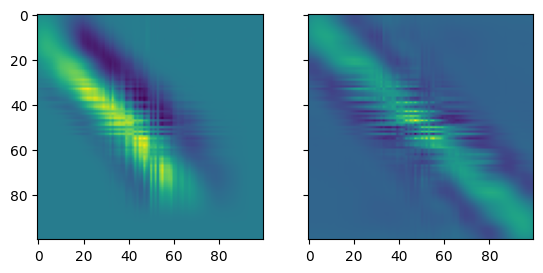

In [ ]:
if True:
     Visualinputsize = 50 # input size and network size]
     FullN = 100
     CDinputsize = 2 # cd signal size
     hiddensize=FullN # hidden layer size of rnn
     visualRange = 100 # -50~50 degree
     SacSupress = False # flag of saccade supression
     #time_step = 250 #150
     #start_time = 250
     saccde_onset = 150 # saccade onset 200ms 150ms
     visual_sigma = 9
     input_pattern = 0 # 0 : memory saccade,1: visual guided,2: mix
     #model =  RNNNet(Visualinputsize,CDinputsize,hiddensize)
     model =  RNNNet(FullN,CDinputsize,hiddensize)
     model_frame = os.path.join('cpkt','rnn-'+str(input_pattern)+str(640)+'.pt')
     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
     model.load_state_dict(torch.load(model_frame,map_location=device))
inputsize=FullN
weight = model.full_h2h.weight.data.squeeze().cpu()
wasy = weight[:,:hiddensize*CDinputsize]
wL = wasy[:,1::2].T
wS = weight[:,-hiddensize:].T # symmetry connections static bump

tmp_w=np.zeros((inputsize,inputsize))

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True,dpi=100)
ax[0].imshow(wL)
ax[1].imshow(wS)


In [ ]:
model

RNNNet(
  (rnn): CTRNN(
    (full_h2h): Linear(in_features=960, out_features=320, bias=True)
    (input2h): Conv1d(1, 1, kernel_size=(31,), stride=(1,), padding=(15,), padding_mode=circular)
    (layer_norm): LayerNorm((200,), eps=1e-05, elementwise_affine=False)
  )
)

In [ ]:
model_frame

'cpkt/rnn-0480.pt'